# Configuration and parameterization tutorial

This notebook outlines the steps required to generate the files used to configure the [vadose](../docs/_build/html/vadoseZone.html), [groundwater](../docs/_build/html/groundwaterZone.html), and [channel](../docs/_build/html/channel.html) zones associated with each [REW](../docs/_build/html/REW.html).

In [1]:
%matplotlib inline
import os
import sys
from os.path import dirname
import pickle
import gdal
import fiona
import glob
import shapely
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pylab
import geopandas as gp
import seaborn as sns
import pyproj
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','1_data_preparation'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','2_hillslope_discharge'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','lib'))
from vadoseZone import LaioVadoseZone, PorporatoVadoseZone, PorporatoPreferentialVadoseZone, SimpleRockMoistureZone
from groundwaterZone import GroundwaterZone, NonlinearReservoir, NonlinearReservoir, TwoLinearReservoir, Melange, TwoParallelLinearReservoir
# from channel import TrapezoidalChannel

This tutorial assumes that an REW network has previously been extracted using the network extraction GRASS tool provided in the data preparation folder. Instructions for running this tool can be found in the [GRASS GIS tutorial](). 

Three python files are used for model configuration and parameterization, all of which can be found in the `1_data_preparation` directory of the model folder. 

##  1. Prepare model configuration - `model_config`

This configuration script can be edited to change the particulars of models' numerical solvers, as well as the start and stop dates for running the model. Simply run the script to write the configuration data to a file. 

In [2]:
from prep import model_config
model_config()
model_config = pd.read_pickle(os.path.join(parent_dir,'model_data','model_config.p'))

Keys of the model configuration dictionary include:
* `start_date` (datetime instance): Start date for running model
* `stop_date` (datetime instance): Stop date for running model
* `spinup_date` (datetime instance): Date after which model has spun up. Only calibrate model after this date.
* `Tmax` (float): Number of days of simulation
* `dt_hillslope` (float): Hillslope simulation timestep in days
* `dt_channel` (float): Channel simulation timestep in days
* `resample_freq_hillslope` (float): Frequency at which to resample forcing data depending on timestep to solve the hillslope model
* `resample_freq_channel` (float): Frequency at which to resample forcing data depending on timestep to solve the channel model
* `timestamps_hillslope` (datetimes): Times at which to simulate hillslope dynamics
* `timestamps_channel` (datetimes): Times at which to simulate channel dynamics

To change any of these model configuration variables, use your favorite text editor to alter their values in the `prep_model_config.py` file, then re-run the script. 

There are some restrictions on allowable values of these configuration variables. All model time units are expressed in days, and the minimum model timestep is one minute, therefore, `dt_hillslope` and `dt_channel` must be greater than or equal to $\frac{1}{1440}$ days. 

The `spinup_date` is a user specified date after which initial model solution transients can be considered negligible. This date is important for calibration, as the model is only calibrated using model generated data after `spinup_date`. The model itself, however, is run from `start_date` to `stop_date`.

In [3]:
print("\nModel run start date is: %s \nModel is spun up after: %s \nModel run end date is: %s" % (str(model_config['start_date']), str(model_config['spinup_date']), str(model_config['stop_date'])))


Model run start date is: 2010-01-01 
Model is spun up after: 2013-10-01 
Model run end date is: 2017-09-30


## 2. Scraping REW Topology and Geometry - `rew_config.py`

This python script converts GIS data related to stream network topology and physical characteristics (see [GRASS GIS tutorial]()) into a Pandas dataframe that is written to `rew_config.p` in the `model_data directory`. 

Watershed with REW sub-basins. 
All stream network information is stored in rew_config.p.
e.g., streams 18 and 14 feed into stream 19.


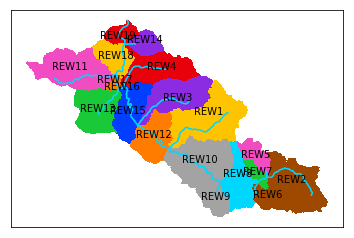

In [4]:
from prep import rew_config
rew_config()

rew_config = pd.read_pickle(os.path.join(parent_dir,'model_data','rew_config.p'))
basins = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
basins_shape = gp.GeoDataFrame.from_file(basins)
basins_shape['coords'] = basins_shape['geometry'].apply(lambda x: x.representative_point().coords[:])
basins_shape['coords'] = [coords[0] for coords in basins_shape['coords']]

cs = sns.color_palette('bright',len(basins_shape)+1)
ax1 = basins_shape.plot(color=cs)
for idx, row in basins_shape.iterrows():
    print_str = 'REW' + str(row['cat'])
    plt.annotate(s=print_str, xy=row['coords'],
                 horizontalalignment='center',fontsize=10)

streams = glob.glob(os.path.join(parent_dir,'raw_data','streams_poly','*.shp'))[0]
streams_shape = gp.GeoDataFrame.from_file(streams)
streams_shape.plot(ax=ax1,color=cs[-1])

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.patch.set_facecolor('white')
rew_id = max(rew_config.keys())
prev_str01 = str(int(rew_config[rew_id]['prev_str01']))
prev_str02 = str(int(rew_config[rew_id]['prev_str02']))
title_str = 'Watershed with REW sub-basins. \n'
title_str += 'All stream network information is stored in rew_config.p.\n'
title_str += ("e.g., streams %s and %s feed into stream %s." % (prev_str01,prev_str02,rew_id))
print(title_str)

## 3. Parameterize the Model - `rew_params`

### - The parameter list

This final script writes into `model_data` the parameter set for each REW [channel](../docs/_build/html/channel.html) instance, as well as for each unique REW *parameter group*. A REW *parameter group* is a collection of REWs which share physiographic features and are thus parameterized with identical data. Parameter groups are determined using the raster located at `/raw_data/paramter_groups/parameter_groups.tif`. This raster must be in place for the model to run. REWs may also be distributed amongst *climate groups*. A *climate group* is a collection of REWs which share climatic features and are thus forced with identical data. If a climate groups raster is found at `/raw_data/climate_groups/climate_groups.tif`, then climate groups are assigned according to this raster. For REWs which share both a *parameter group* and a *climate group*, only a single instance of the hillslope module will need to be solved; this potentially decreases the computational demand of the model. REWs that share both climate and parameter groups are deemed part of the same *group*. 

The user will determine the manner in which REWs are distributed amongst climate and parameter groups. For heterogeneous watersheds, it may be beneficial to lump REWs into the same parameter group if the REWs share similiar critical zone architecture and vegetation cover. 

In [5]:
from prep import rew_params
rew_params()

channel_params = pd.read_pickle(os.path.join(parent_dir,'model_data','channel_params.p'))
parameter_group_params = pd.read_pickle(os.path.join(parent_dir,'model_data','parameter_group_params.p'))

for parameter_group_number in parameter_group_params.keys():
    len_group = len(parameter_group_params[parameter_group_number])
    parameter_list = [param for param in parameter_group_params[parameter_group_number].keys()]
    print_str = "\nParameter group " + str(parameter_group_number) + " requires specification of the following parameters/variables: \n"
    print_str += ", ".join(parameter_list)
    print(print_str + '\n')



Parameter group 1 requires specification of the following parameters/variables: 
eta, res1, k1, gz, alpha, f, vz, res2, b, smaxS, smaxR, storageR, storageS, a, k12


Parameter group 2 requires specification of the following parameters/variables: 
eta, storageGZ, gz, vz, b, storageVZ, a, smax, capacity



### - Model structure for each parameter group

In addition to model parameterization, model structure can be changed between REW parameter groups. For each parameter group in the `parameter_group_params` dictionary, classes for both the vadose zone model (dictionary key `vz`) and the groundwater zone model (dictionary key `gz`) must be specified. In this way, groundwater and vadose zone representations can vary across the landscape. 

In [6]:
for parameter_group_number in parameter_group_params.keys():
    vz = str(parameter_group_params[parameter_group_number]['vz'])
    gz = str(parameter_group_params[parameter_group_number]['gz'])
    print_str = "\nParameter group " + str(parameter_group_number) + " consists of a " + vz + " vadose zone model \n"
    print_str += "and a " + gz + " groundwater zone model."
    print(print_str + '\n')


Parameter group 1 consists of a <class 'vadoseZone.PreferentialRockMoistureZone'> vadose zone model 
and a <class 'groundwaterZone.LinearToNonlinearReservoir'> groundwater zone model.


Parameter group 2 consists of a <class 'vadoseZone.PorporatoVadoseZone'> vadose zone model 
and a <class 'groundwaterZone.Melange'> groundwater zone model.





### - Specify parameter ranges

To facilitate model calibration, realistic parameter ranges can optionally be specified using the `param_ranges` dictionary. Only parameters with specified ranges will be calibrated, others will remain set to the initial value specified in `parameter_group_params` or `channel_params`. 

In [7]:
parameter_ranges = pd.read_pickle(os.path.join(parent_dir,'model_data','parameter_ranges.p'))
try: 
    for parameter_group_number in list(parameter_group_params):
        parameter_name = list(parameter_ranges[parameter_group_number])[0]
        parameter_range = parameter_ranges[parameter_group_number][parameter_name]
        print_str = "\nThe parameter '" + parameter_name + "' from parameter group " + str(parameter_group_number) + " will be sampled from the interval " + str(parameter_range) + " during calibration."
        print(print_str + '\n')
except:
    print('No calibration parameters were specified. Do not run any calibration notebooks.')


The parameter 'smaxS' from parameter group 1 will be sampled from the interval (1, 10) during calibration.


The parameter 'eta' from parameter group 2 will be sampled from the interval (0.2, 1.0) during calibration.



# Channel gradient vs area relationship

Exploring this relationship for fun

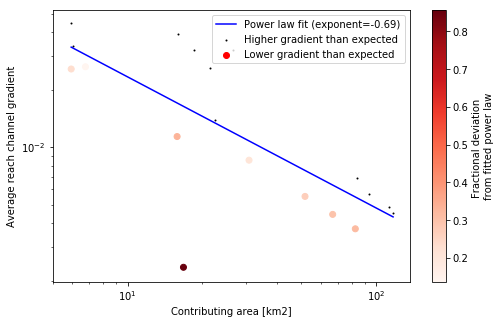

In [9]:
import matplotlib
area = []
gradient = []
keys = list(rew_config)
for key in keys:
    gradient.append(rew_config[key]['gradient'])
    up = rew_config[key]['upstream_area']*1e-10
    area.append(rew_config[key]['area_sqkm'] + up)
    
area = np.array(area)
gradient = np.array(gradient)
m,b = np.polyfit(np.log(area), np.log(gradient), 1)
yfit = np.exp(b)*area**m


idx = np.argsort(area)
f,ax = plt.subplots(1,figsize=(8,5))
ax.loglog(area[idx], yfit[idx], label='Power law fit (exponent=%.2f)'%m, c='blue')
resid = np.abs((gradient-yfit)/yfit)
idx_above = (yfit<=gradient)
ax.scatter(area[idx_above], gradient[idx_above], c='k', s=1, label='Higher gradient than expected')
idx = (yfit>=gradient)&(gradient>=9e-5)
# plt.scatter(area[idx],gradient[idx], c=resid[idx], norm=matplotlib.colors.LogNorm())
im1 = ax.scatter(area[idx],gradient[idx], c=resid[idx], cmap='Reds', label='Lower gradient than expected')
leg = ax.legend(loc='upper right')
LH = leg.legendHandles

LH[2].set_color('r')   

cbar = f.colorbar(im1, ax=ax)
cbar.set_label('Fractional deviation \nfrom fitted power law')
ax.set_xlabel('Contributing area [km2]')
ax.set_ylabel('Average reach channel gradient')
resid[idx_above] = np.nan
df = pd.DataFrame({'cat':keys, 'error':resid})
# plt.savefig('/Users/daviddralle/Desktop/gradient_vs_area_pd.pdf')
# basins = gp.read_file('../../raw_data/basins_poly/basins_poly.shp')
# basins = basins.merge(df, on='cat')
# basins.to_file('/Users/david.dralle/Desktop/basins.shp')
# plt.savefig('/Users/david.dralle/Desktop/gradient_vs_area.pdf')